# TrySelectingMetricSpatially #

**Started 2016-04-27** -- Try loading a previously-evaluated metric and selecting on spatial regions. On my laptop, running e.g. TransientMetric on one OpSim run using a relatively relaxed sql constraint can take up to four hours, so I want a way to try different selections on the results without having to re-run the metric each time. This notebook is my attempt to do so.

Most of the pieces are plundered from sims_maf or maf_contrib, but astropy is also used to handle co-ordinate conversions. (That functionality for arrays of coordinates must lie somewhere within maf or maf_contrib, I just haven't found it yet.)

**UPDATE 2016-04-29** -- this seems to work! The figures are still being dumped into the working directory, which is not ideal... I have updated the paths below using **metricDir** as an absolute path to the directory in which the metric evals are stored. Change **metricDir** to use an alternate location.

Since I haven't learned yet how to set output filenames for individual plots from the bundles, I use shutil to copy the standard filename into new files. 

 Here's how I imagine this working:

* Load the metric of interest, assign RA, DEC values to each healpix and use astropy to convert (RA, DEC) --> (l, b);

* To select regions, either:

    * Parameterize the region somehow and use naiive selection on the plane; or,

    * Compute (or load) a stellar density map - say, rmag < 28 as in PeterY's **StellarDensityMap.ipynb** in **maf_contrib** - for the same opsimdb file and NSIDE as the metric we want, and use density to select.

* Boolean-select on |b| and on density

* Select metric values (a 1D array) on the boolean resulting;

* Do statistics on that sample.

In [506]:
%matplotlib inline

In [507]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

In [508]:
import copy

In [509]:
import shutil

In [510]:
from matplotlib.colors import LogNorm

In [511]:
# healpy 
import healpy as hp

In [512]:
# Loading pre-ran metric results
import lsst.sims.maf.metricBundles as mb

In [513]:
# import statements from the plot-handling notebook
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
from lsst.sims.maf.metricBundles import MetricBundle, MetricBundleGroup, makeBundlesDictFromList

In [514]:
# Copied file sims_utils/python/lsst/sims/utils/healpyUtils.py into the working directory
import healpyUtils

In [515]:
# Some stuff we'll need to manipulate coordinates easily
from astropy.coordinates import SkyCoord

### Set the source path for precomputed metric output ###

In [516]:
# uncomment to follow the convention of the repository. 
# Note that then the outputs will be submittable to the repository.

#topDir = '/Users/clarkson/Progs/Projects/lsstScratchWIC'
#metricDir = '%s/data/metricOutputs' % (topDir)

# Otherwise we assume this is already being run from the directory 
# holding pre-computed metric directories.
metricDir=os.getcwd()

# update - for my system
metricDir='/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411'

### Select the run and metric we want ##

To determine all the FoMs, run-all below with different options commented in the pair of cells below.

In [553]:
# for sanity when using, set a string for which quantity we're talking about?
sMetric = 'properMotion'
#sMetric = 'parallax'

In [554]:
# construct the path and filename from our choice of input
#sOpSim = 'minion_1020'
sOpSim = 'minion_1016'
#sOpSim = 'astro_lsst_01_1004'

### Other pieces to construct file path from outputs of runAstrom.py ###

In [555]:
# some strings to build up the run and directory
sSQL = 'night_lt_10000'
sSelDir = 'nside64_ugrizy_n10000_r21p0_lims'

In [556]:
# Let's set metricDir to a particular place...
#inputDir='%s/metricEvals/minion_1016_nside64_ugrizy_n10000_r21p0_lims' % (metricDir)
#inputFil='minion_1016_%s_night_lt_10000_HEAL.npz' % (sMetric)

inputDir='%s/metricEvals/%s_%s' % (metricDir, sOpSim, sSelDir)
inputFil='%s_%s_%s_HEAL.npz' % (sOpSim, sMetric, sSQL)

print inputDir
print inputFil


/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411/metricEvals/minion_1016_nside64_ugrizy_n10000_r21p0_lims
minion_1016_properMotion_night_lt_10000_HEAL.npz


In [557]:
# what happens with ps1?
#inputDir='%s/metricEvals/minion_1020_nside64_ugrizy_n10000_r21p0_lims' % (metricDir)
#inputFil='minion_1020_%s_night_lt_10000_HEAL.npz' % (sMetric)

## Test loading pre-computed metric ##

In [558]:
# check that we can read the path
inPath = '%s/%s' % (inputDir, inputFil)
print os.access(inPath, os.R_OK)

True


In [559]:
myBundle = mb.createEmptyMetricBundle()

In [560]:
myBundle.read(inPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Test plotting the spatial map for this metric bundle ##

In [561]:
print myBundle.metric.name

properMotion


In [562]:
print myBundle.metric.colInfo

In [563]:
# Can we choose which plots to produce?
# help(myBundle.setPlotFuncs)   ## Yes but is not immediately obvious to me...
print myBundle.plotFuncs  # can we change this?
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()] #, plots.HealpixSDSSSkyMap()]
myBundle.setPlotFuncs(plotFuncs)

[<lsst.sims.maf.plots.spatialPlotters.HealpixSkyMap object at 0x129f9b250>, <lsst.sims.maf.plots.spatialPlotters.HealpixHistogram object at 0x12bfedb50>, <lsst.sims.maf.plots.spatialPlotters.HealpixPowerSpectrum object at 0x127aba450>]


In [564]:
# standardise the cmap throughout
cMap = cm.cubehelix_r

{'Histogram': 2, 'SkyMap': 1}

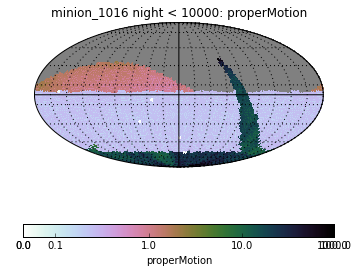

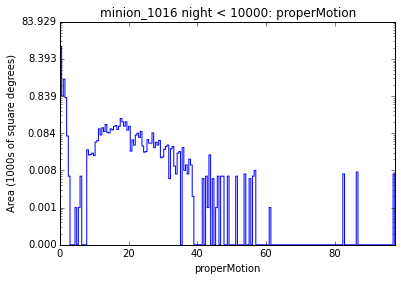

In [590]:
# aha - so we CAN just plot by calling the method!! Niiice... OK now see if we can change any parameters
#if os.access(sFigNam, os.R_OK):
#    os.remove(sFigNam)

thisPlotDict = {'logScale':True, 'cmap':cMap}# cm.RdBu_r}

vmin = np.min(myBundle.metricValues)
vmax = np.max(myBundle.metricValues)

thisPlotDict['xMax'] = vmax
thisPlotDict['xMin'] = vmin

myBundle.setPlotDict(thisPlotDict)
myBundle.plot(savefig=True)

In [591]:
# until I work out how to change the output plot name, use os.copy to produce a file copy 
sFigNam='thumb.%s_SkyMap.png' % (inputFil.split('.')[0])

if os.access(sFigNam, os.R_OK):
        
    sOut = 'MW_Astrom_FoM_%s_%s_all_skymap.png' % (sMetric, sOpSim)
    shutil.copy(sFigNam, sOut)

## Try lifting spatial information out ## 

Following an idea suggested by Peter Yoachim using healpy and healpyUtils.py to do co-ordinate conversion

In [592]:
npix = myBundle.metricValues.size
nside = hp.npix2nside(npix)
print npix, nside

49152 64


In [593]:
ra, dec = healpyUtils.hpid2RaDec(nside, np.arange(npix))
print np.shape(ra)
print np.shape(dec)
print np.min(ra), np.max(ra)
print np.min(dec), np.max(dec)

(49152,)
(49152,)
0.0 359.296875
-89.2690292916 89.2690292916


In [594]:
# feed these RA, DEC values into an astropy coords object
cc = SkyCoord(ra=np.copy(ra), dec=np.copy(dec), frame='fk5', unit='deg')

### Try test-plotting using something basic ###

In [595]:
np.shape(myBundle.metricValues)

(49152,)

In [596]:
def getAvoidanceLatitudes(galL, peakDeg=10., taperDeg=80., constWidth=5.):
    
    """Returns the (positive) GP avoidance region for input galactic longitude"""
    
    # The following is adapted from spatialPlotters.py in sims_maf, method _plot_mwZone
    
    # astropy uses 0 <= glon <= 2pi, so we shift the input values accordingly.
    galL_use = np.copy(galL)
    gSec = np.where(galL_use > np.pi)
    galL_use[gSec] -= 2.0 * np.pi
    
    peakWidth=np.radians(peakDeg)
    taperLength=np.radians(taperDeg)
    val = peakWidth * np.cos(galL_use / taperLength * np.pi / 2.)
    
    # Remove the cosine peak at anticenter
    gFar = np.where(np.abs(galL_use) > taperLength)[0]
    val[gFar] = 0.

    val += np.radians(constWidth)
    
    return val

<matplotlib.colorbar.Colorbar instance at 0x13075def0>

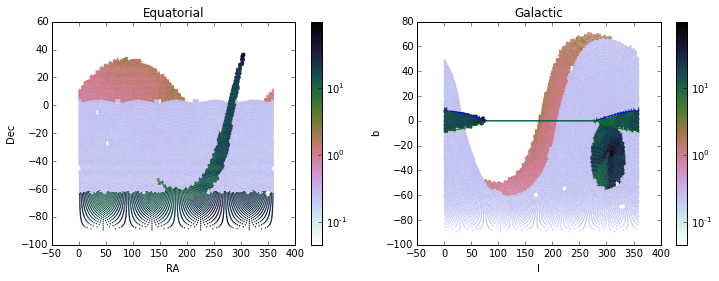

In [597]:
# Chart the avoidance regions for the plane:
step = 0.02
galL = np.arange(-np.pi, np.pi + step / 2., step) + np.pi
galB1 = getAvoidanceLatitudes(galL, 8., 80., 0.)
galB2 = 0. - galB1

# all in degrees
r2deg = 180./np.pi
galL *= r2deg
galB1 *= r2deg
galB2 *= r2deg

plt.figure(1, figsize=(12,4))
plt.clf()
plt.subplot(121)
plt.scatter(cc.ra, cc.dec, \
            c=myBundle.metricValues, edgecolor='none', s=2, \
           cmap=cMap, norm=LogNorm())
plt.title('Equatorial')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

plt.subplot(122)
plt.scatter(cc.galactic.l, cc.galactic.b, \
            c=myBundle.metricValues, edgecolor='none', s=2, \
           cmap=cMap, norm=LogNorm())

plt.plot(galL, galB1)
plt.plot(galL, galB2)

plt.title('Galactic')
plt.xlabel('l')
plt.ylabel('b')
plt.colorbar()

In [598]:
# now try selecting spatially for (region, ~region)
# mVals = myBundle.metricValues  # view for convenience

r2deg = 180./np.pi
gLon = np.asarray(cc.galactic.l)
gLat = np.asarray(cc.galactic.b)

# Set a conservative "plane" region 
latAvoidPos = getAvoidanceLatitudes(gLon*np.pi/180., constWidth=0.0, peakDeg=7.)
latAvoidPos *= r2deg

# Perform the selection
bPln = (gLat < latAvoidPos) & (gLat > 0.-latAvoidPos)

# For the "main" survey region, try excising the south polar cap for 
# a fairer comparison, and allow a bit of slop in the avoidance region
capDecMax = -60.

bNonCap = (np.asarray(cc.dec) > capDecMax)
latNonPlnPos = getAvoidanceLatitudes(gLon*np.pi/180., constWidth=0., peakDeg=10., taperDeg=115.)
latNonPlnPos *= r2deg

bNotPln = (gLat > latNonPlnPos) | (gLat < 0.-latNonPlnPos)

bAway = (bNotPln) & (bNonCap) #& (~bPln)

print np.size(np.where(bPln))
print np.size(np.where(bAway))

1700
42769


<matplotlib.colorbar.Colorbar instance at 0x129f1d1b8>

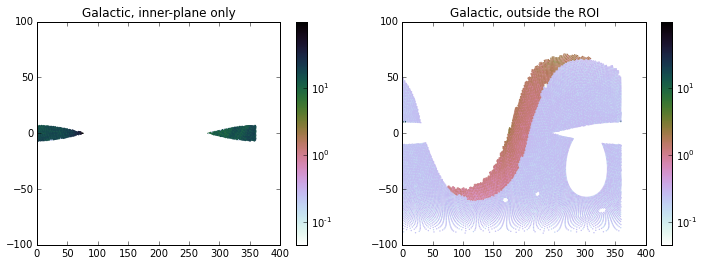

In [599]:
# set minmax ranges for plots
vmin = np.min(myBundle.metricValues)
vmax = np.max(myBundle.metricValues)

# Let's try the plot again, this time sticking with galactics and selecting out our regions.
plt.figure(2, figsize=(12,4))
plt.clf()
plt.subplot(121)
plt.scatter(cc.galactic.l[bPln], cc.galactic.b[bPln], \
            c=myBundle.metricValues[bPln], edgecolor='none', s=2, \
           cmap=cMap, norm=LogNorm(), \
           vmin=vmin, vmax=vmax)

plt.xlim(0, 400)
plt.ylim(-100,100)
plt.title('Galactic, inner-plane only')
plt.colorbar()

plt.subplot(122)
plt.scatter(cc.galactic.l[bAway], cc.galactic.b[bAway], \
            c=myBundle.metricValues[bAway], edgecolor='none', s=2, \
           cmap=cMap, norm=LogNorm(), \
           vmin=vmin, vmax=vmax)

plt.xlim(0, 400)
plt.ylim(-100,100)
plt.title('Galactic, outside the ROI')
plt.colorbar()

## Compute statistics on the input metric ##

In [600]:
# in the region of interest...
print "Plane: median %.2e" % (np.median(myBundle.metricValues[bPln]))
print "Plane: stddev %.2e" % (np.std(myBundle.metricValues[bPln]))
#print myBundle.metricValues[bPln]

Plane: median 1.66e+01
Plane: stddev 5.89e+00


In [601]:
# NOT in the region of interest...
print "Outside avoidance region: median %.2e" % (np.median(myBundle.metricValues[bAway]))
print "Outside avoidance region: stddev %.3e" % (np.std(myBundle.metricValues[bAway]))
#print myBundle.metricValues[~bPln]

Outside avoidance region: median 1.86e-01
Outside avoidance region: stddev 4.839e-01


In [602]:
# write these to a human-readable text file...
sHuman = 'regSel_%s.txt' % (inputFil.split('.')[0])
wObj = open(sHuman, 'w')
wObj.write('########### \n')
wObj.write('# Result of TrySelectingMetricSpatially.ipynb \n')
wObj.write('# Input file: %s \n' % (inputFil))
wObj.write('# Input directory: %s \n' % (inputDir))
wObj.write('# Quantity %s \n' % (sMetric))
wObj.write('########### \n')

wObj.write("Inner plane: median %.2e \n" % (np.median(myBundle.metricValues[bPln])) )
wObj.write("Inner plane: stddev %.2e \n" % (np.std(myBundle.metricValues[bPln])) )
wObj.write('### \n')
wObj.write("Outside avoidance region: median %.2e \n" % (np.median(myBundle.metricValues[bAway])) )
wObj.write("Outside avoidance region: stddev %.3e \n" % (np.std(myBundle.metricValues[bAway])) )

wObj.close()

**WARNING** - histogram may be a bit dangerous, I don't remember if the healpix area needs to be taken into account on the sky... 

/Users/clarkson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/clarkson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


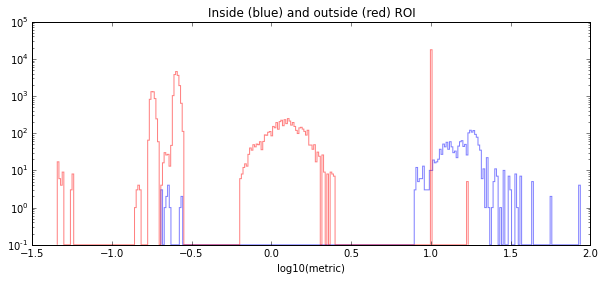

In [603]:
plt.figure(3, figsize=(10,4))
plt.clf()

dum = plt.hist(np.log10(myBundle.metricValues[bPln]), bins=250, \
               alpha=0.5, log=True, color='b', \
              histtype='step', normed=False)
dum = plt.hist(np.log10(myBundle.metricValues[bAway]), bins=250, \
               alpha=0.5, log=True, color='r', \
              histtype='step', normed=False)

plt.xlabel('log10(metric)')
plt.title('Inside (blue) and outside (red) ROI')

## Next step: Use maf machinery to make nice plots with selection boolean applied ##

It is not clear to me how the metricBundle is handling missing data. Here are some entries:

In [604]:
print myBundle.metricValues[0:5]
print myBundle.metricValues[-5:-1]

[-- -- -- -- --]
[22.409828574103937 13.953204878181895 30.787320212997773
 30.787320212997773]


Here is a cargo-cult way to make this work... copy the entire bundle into a new object and set the mask appropriately.

In [605]:
myBundleNoPlane = copy.deepcopy(myBundle)
myBundleAvoid = copy.deepcopy(myBundle)

In [606]:
myBundleAvoid.metricValues.mask[~bPln] = True

In [607]:
# set some plot characteristics of interest
sepPlotDict = copy.deepcopy(thisPlotDict)
sepPlotDict['cmap'] = cMap
sepPlotDict['xMax'] = vmax
sepPlotDict['xMin'] = vmin

{'Histogram': 2, 'SkyMap': 1}

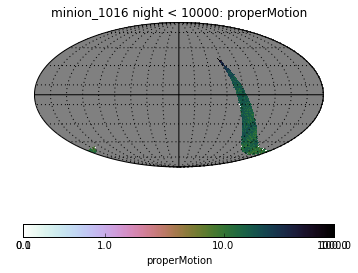

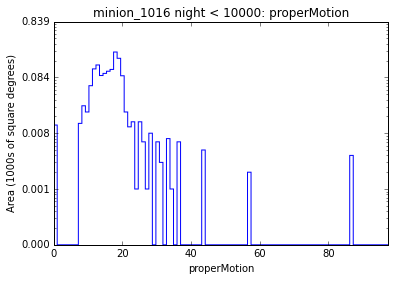

In [608]:
myBundleAvoid.setPlotDict(sepPlotDict)
myBundleAvoid.plot(savefig=True)

In [609]:
if os.access(sFigNam, os.R_OK):
    sOut = 'MW_Astrom_FoM_%s_%s_plane_skymap.png' % (sMetric, sOpSim)
    shutil.copy(sFigNam, sOut)

In [610]:
myBundleNoPlane.metricValues.mask[~bAway] = True

{'Histogram': 2, 'SkyMap': 1}

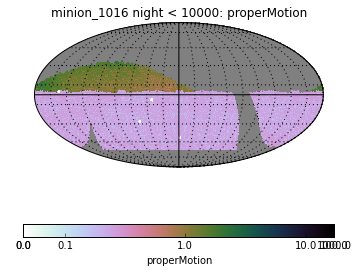

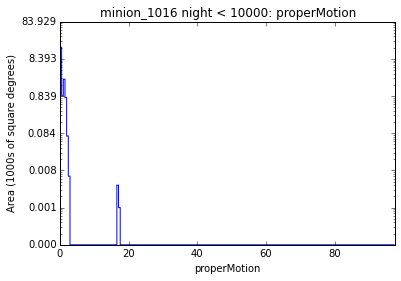

In [611]:
myBundleNoPlane.setPlotDict(sepPlotDict)
myBundleNoPlane.plot(savefig=True)

In [612]:
if os.access(sFigNam, os.R_OK):
    sOut = 'MW_Astrom_FoM_%s_%s_nonPlane_skymap.png' % (sMetric, sOpSim)
    shutil.copy(sFigNam, sOut)

### Use metric's own methods to estimate summary values ###

To be completed!!

In [613]:
! pwd

/Users/clarkson/Data/LSST/OpSimRuns/opsim20160411/testSpatial
